In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import random
from pathlib import Path

In [2]:
# Define paths with proper resolution (similar to previous code)
cwd = Path.cwd()
candidates = [
    cwd / "Tea Leaf Disease Dataset",
    cwd.parent / "Tea Leaf Disease Dataset",
    cwd / "Data" / "Raw" / "Tea Leaf Disease Dataset",
    cwd.parent / "Data" / "Raw" / "Tea Leaf Disease Dataset",
]

In [3]:
# Find the correct dataset path
cleaned_path = None
for candidate in candidates:
    if candidate.exists():
        cleaned_path = candidate
        break

if cleaned_path is None:
    # If not found, try to find any folder containing the dataset
    potential_dirs = []
    for root, dirs, files in os.walk(cwd.parent):
        if "Tea Leaf Disease Dataset" in dirs:
            potential_dirs.append(Path(root) / "Tea Leaf Disease Dataset")

    if potential_dirs:
        cleaned_path = potential_dirs[0]
        print(f"Found dataset at: {cleaned_path}")
    else:
        raise FileNotFoundError("Could not find 'Tea Leaf Disease Dataset'. Please check the path.")
else:
    print(f"Found dataset at: {cleaned_path}")

Found dataset at: C:\Users\dell\Desktop\AI_Project\Data\Tea Leaf Disease Dataset


In [4]:
# Create resized dataset path in the same parent directory
resized_path = cleaned_path.parent / "Tea Leaf Disease Dataset Resized"
os.makedirs(resized_path, exist_ok=True)

print(f"Original dataset path: {cleaned_path}")
print(f"Resized dataset path: {resized_path}")

target_size = (224, 224)  # Standard size for CNN models

Original dataset path: C:\Users\dell\Desktop\AI_Project\Data\Tea Leaf Disease Dataset
Resized dataset path: C:\Users\dell\Desktop\AI_Project\Data\Tea Leaf Disease Dataset Resized


In [5]:
# First, let's check what's actually in the dataset directory
print("Contents of dataset directory:")
try:
    items = os.listdir(cleaned_path)
    print(f"Found {len(items)} items:")
    for item in items:
        item_path = cleaned_path / item
        if item_path.is_dir():
            file_count = len([f for f in os.listdir(item_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  📁 {item}: {file_count} images")
        else:
            print(f"  📄 {item}")
except Exception as e:
    print(f"Error reading directory: {e}")

Contents of dataset directory:
Found 6 items:
  📁 algal_spot: 5497 images
  📁 brown_blight: 4908 images
  📁 gray_blight: 5537 images
  📁 healthy: 5492 images
  📁 helopeltis: 5482 images
  📁 red_spot: 5505 images


In [6]:
# Analyze original image dimensions
widths = []
heights = []
aspect_ratios = []
valid_categories = []

print("\nAnalyzing original image dimensions...")

# Get only directory categories (skip files)
categories = [cat for cat in os.listdir(cleaned_path)
              if (cleaned_path / cat).is_dir() and not cat.startswith(('.', '_'))]

if not categories:
    # Try alternative approach - look for any subdirectories
    categories = []
    for item in os.listdir(cleaned_path):
        item_path = cleaned_path / item
        if item_path.is_dir() and not item.startswith(('.', '_')):
            categories.append(item)

    if not categories:
        raise FileNotFoundError(f"No valid category folders found in {cleaned_path}")

print(f"Found categories: {categories}")

for category in categories:
    src_folder = cleaned_path / category
    dst_folder = resized_path / category
    os.makedirs(dst_folder, exist_ok=True)

    # Get image files
    image_files = [f for f in os.listdir(src_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Warning: No images found in {category}")
        continue

    valid_categories.append(category)
    print(f"Processing {category}: {len(image_files)} images")

    for file in image_files:
        file_path = src_folder / file
        img = cv2.imread(str(file_path))  # Convert Path to string for cv2
        if img is not None:
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)

if not widths:  # Check if any images were found
    raise FileNotFoundError("No valid images found in the dataset. Please check the file paths and formats.")


Analyzing original image dimensions...
Found categories: ['algal_spot', 'brown_blight', 'gray_blight', 'healthy', 'helopeltis', 'red_spot']
Processing algal_spot: 5497 images
Processing brown_blight: 4908 images
Processing gray_blight: 5537 images
Processing healthy: 5492 images
Processing helopeltis: 5482 images
Processing red_spot: 5505 images


In [7]:
# Visualize original dimensions
plt.figure(figsize=(6,6))

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

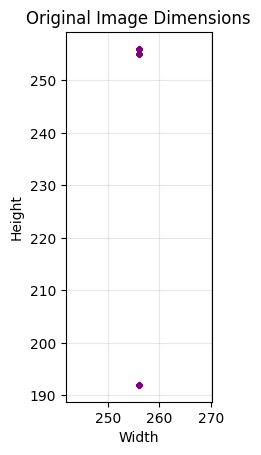

In [17]:
# Scatter plot of dimensions
plt.subplot(1,3,1)
plt.scatter(widths, heights, alpha=0.3, color="purple", s=10)
plt.title("Original Image Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True, alpha=0.3)

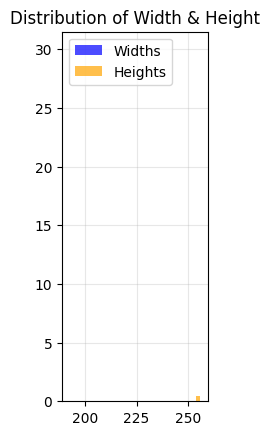

In [18]:
# Histogram of widths and heights
plt.subplot(1, 3, 2)
plt.hist(widths, bins=30, color='blue', alpha=0.7, label="Widths", density=True)
plt.hist(heights, bins=30, color='orange', alpha=0.7, label="Heights", density=True)
plt.title("Distribution of Width & Height")
plt.legend()
plt.grid(True, alpha=0.3)

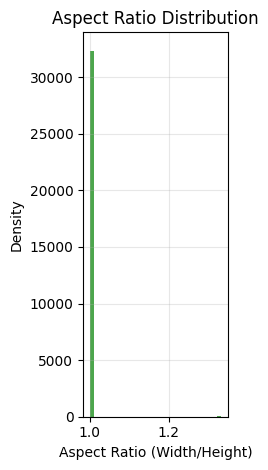

In [19]:
# Aspect ratio distribution
plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=30, color='green', alpha=0.7)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Print statistics
print(f"\nOriginal Dimensions Statistics:")
print(f"Total images analyzed: {len(widths)}")
print(f"Width:  Min={min(widths):.0f}, Max={max(widths):.0f}, Mean={np.mean(widths):.1f}")
print(f"Height: Min={min(heights):.0f}, Max={max(heights):.0f}, Mean={np.mean(heights):.1f}")
print(f"Aspect Ratio: Min={min(aspect_ratios):.2f}, Max={max(aspect_ratios):.2f}, Mean={np.mean(aspect_ratios):.2f}")


Original Dimensions Statistics:
Total images analyzed: 32421
Width:  Min=256, Max=256, Mean=256.0
Height: Min=192, Max=256, Mean=255.9
Aspect Ratio: Min=1.00, Max=1.33, Mean=1.00


In [21]:
# Resize all images
print("\nResizing images...")
resize_method = cv2.INTER_AREA  # Good for downscaling

total_resized = 0
for category in valid_categories:
    src_folder = cleaned_path / category
    dst_folder = resized_path / category

    # Get list of image files
    image_files = [f for f in os.listdir(src_folder)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"Processing {category}: {len(image_files)} images")

    category_resized = 0
    for file in tqdm(image_files, desc=f"Resizing {category}"):
        file_path = src_folder / file
        img = cv2.imread(str(file_path))

        if img is not None:
            # Resize image
            resized_img = cv2.resize(img, target_size, interpolation=resize_method)

            # Save with same name
            cv2.imwrite(str(dst_folder / file), resized_img)
            category_resized += 1

    total_resized += category_resized
    print(f"  ✅ Resized {category_resized} images")

print(f"\nResizing completed! Total images resized: {total_resized}")


Resizing images...
Processing algal_spot: 5497 images


Resizing algal_spot: 100%|██████████| 5497/5497 [00:58<00:00, 93.71it/s] 


  ✅ Resized 5497 images
Processing brown_blight: 4908 images


Resizing brown_blight: 100%|██████████| 4908/4908 [00:41<00:00, 117.66it/s]


  ✅ Resized 4908 images
Processing gray_blight: 5537 images


Resizing gray_blight: 100%|██████████| 5537/5537 [00:42<00:00, 131.08it/s]


  ✅ Resized 5537 images
Processing healthy: 5492 images


Resizing healthy: 100%|██████████| 5492/5492 [00:37<00:00, 147.27it/s]


  ✅ Resized 5492 images
Processing helopeltis: 5482 images


Resizing helopeltis: 100%|██████████| 5482/5482 [00:33<00:00, 161.41it/s]


  ✅ Resized 5482 images
Processing red_spot: 5505 images


Resizing red_spot: 100%|██████████| 5505/5505 [00:40<00:00, 136.77it/s]

  ✅ Resized 5505 images

Resizing completed! Total images resized: 32421


In [22]:
# Verify resized images
resized_widths = []
resized_heights = []

print("\nVerifying resized images...")
for category in valid_categories:
    folder = resized_path / category
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in image_files:
        img = cv2.imread(str(folder / file))
        if img is not None:
            h, w = img.shape[:2]
            resized_widths.append(w)
            resized_heights.append(h)


Verifying resized images...


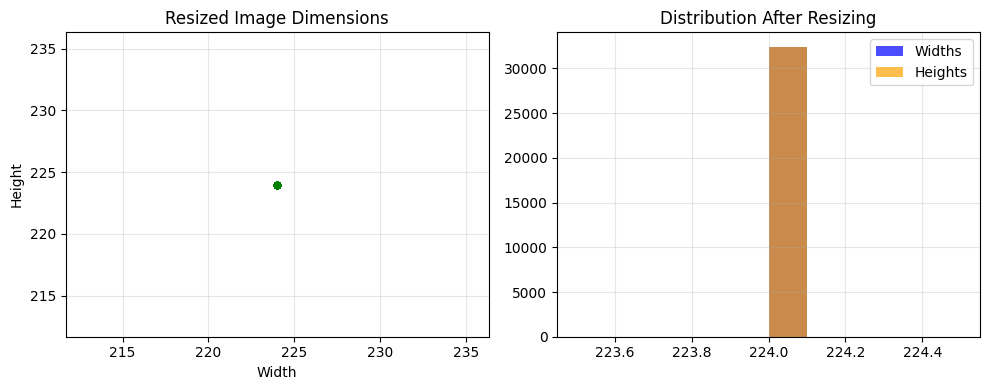

Resized Dimensions: All images are 224x224


In [23]:
# Visualize resized dimensions
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(resized_widths, resized_heights, alpha=0.6, color="green", s=20)
plt.title("Resized Image Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(resized_widths, bins=10, color='blue', alpha=0.7, label="Widths")
plt.hist(resized_heights, bins=10, color='orange', alpha=0.7, label="Heights")
plt.title("Distribution After Resizing")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Resized Dimensions: All images are {target_size[0]}x{target_size[1]}")



Displaying sample resized images...


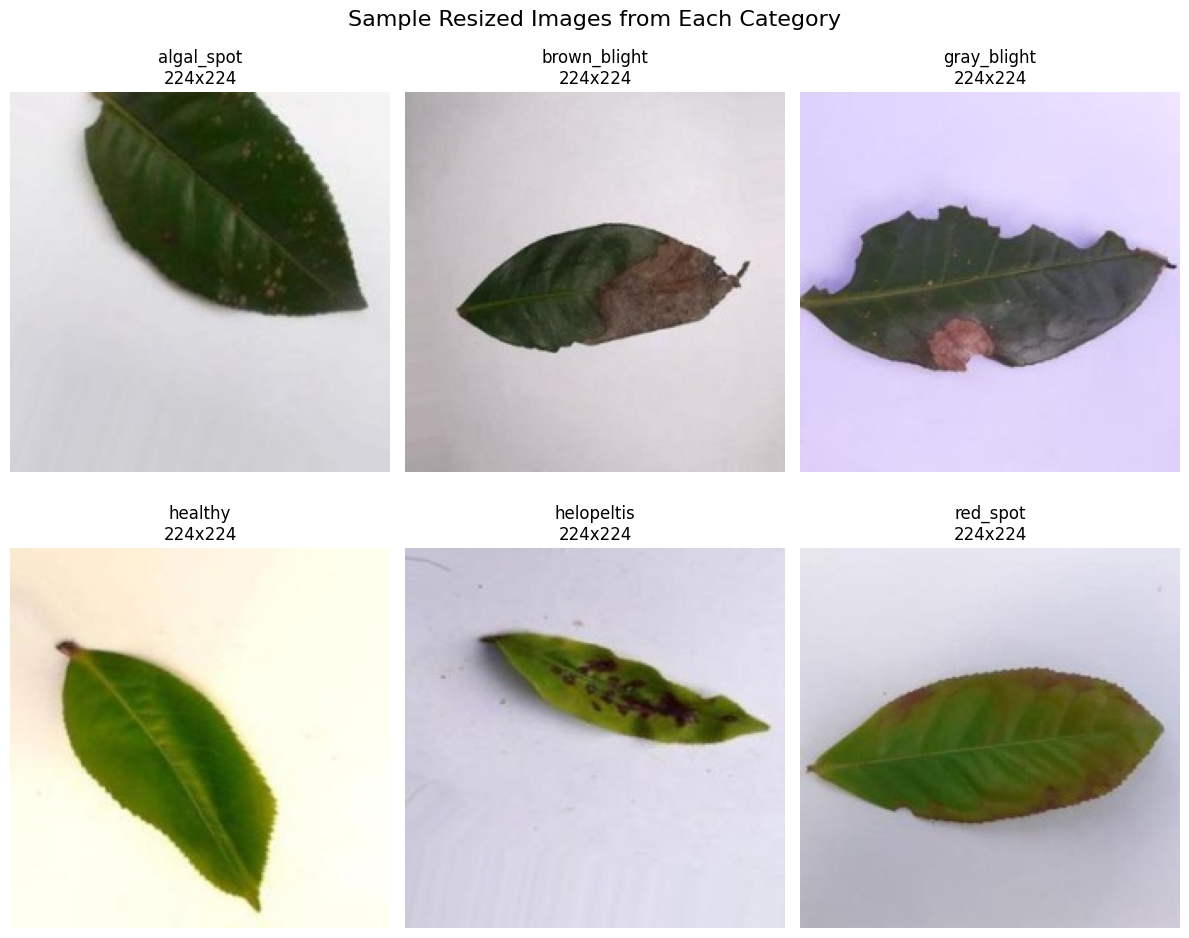

In [24]:
# Display sample resized images
print("\nDisplaying sample resized images...")

plt.figure(figsize=(12, 10))
for i, category in enumerate(valid_categories[:6]):
    sample_folder = resized_path / category
    sample_files = [f for f in os.listdir(sample_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if sample_files:
        sample_file = random.choice(sample_files)
        img_path = sample_folder / sample_file
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 3, i+1)
        plt.imshow(img_rgb)
        plt.title(f"{category}\n{target_size[0]}x{target_size[1]}")
        plt.axis("off")

plt.suptitle("Sample Resized Images from Each Category", fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
# Summary report
print("\n" + "="*50)
print("RESIZING SUMMARY REPORT")
print("="*50)

original_total = sum([len([f for f in os.listdir(cleaned_path / cat)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                     for cat in valid_categories])

resized_total = sum([len([f for f in os.listdir(resized_path / cat)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    for cat in valid_categories])

print(f"Original dataset: {original_total} images")
print(f"Resized dataset:  {resized_total} images")
print(f"Target size:      {target_size[0]}x{target_size[1]} pixels")
print(f"Categories processed: {valid_categories}")

if original_total == resized_total:
    print("✅ All images successfully resized!")
else:
    print(f"⚠️  Image count mismatch: {original_total - resized_total} images may not have been processed")

print("="*50)


RESIZING SUMMARY REPORT
Original dataset: 32421 images
Resized dataset:  32421 images
Target size:      224x224 pixels
Categories processed: ['algal_spot', 'brown_blight', 'gray_blight', 'healthy', 'helopeltis', 'red_spot']
✅ All images successfully resized!
